In [1]:
from keras.models import Sequential , Model
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np

In [7]:
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

In [8]:

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.

In [9]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [10]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

In [11]:
#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=3000, batch_size=32, save_interval=10)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

95 [D loss: 0.010757, acc.: 100.00%] [G loss: 4.866721]
96 [D loss: 0.006945, acc.: 100.00%] [G loss: 4.915061]
97 [D loss: 0.009513, acc.: 100.00%] [G loss: 4.929465]
98 [D loss: 0.009718, acc.: 100.00%] [G loss: 5.035761]
99 [D loss: 0.005661, acc.: 100.00%] [G loss: 5.011829]
100 [D loss: 0.017041, acc.: 100.00%] [G loss: 4.934104]
101 [D loss: 0.007064, acc.: 100.00%] [G loss: 5.174408]
102 [D loss: 0.015605, acc.: 100.00%] [G loss: 5.287426]
103 [D loss: 0.005714, acc.: 100.00%] [G loss: 5.059295]
104 [D loss: 0.005015, acc.: 100.00%] [G loss: 4.895465]
105 [D loss: 0.008323, acc.: 100.00%] [G loss: 4.812455]
106 [D loss: 0.013338, acc.: 100.00%] [G loss: 5.023472]
107 [D loss: 0.029743, acc.: 100.00%] [G loss: 4.873890]
108 [D loss: 0.015930, acc.: 100.00%] [G loss: 5.239632]
109 [D loss: 0.005812, acc.: 100.00%] [G loss: 5.292024]
110 [D loss: 0.017629, acc.: 100.00%] [G loss: 5.108330]
111 [D loss: 0.016078, acc.: 100.00%] [G loss: 5.600002]
112 [D loss: 0.009067, acc.: 100.00%

241 [D loss: 0.478011, acc.: 75.00%] [G loss: 2.173082]
242 [D loss: 0.588769, acc.: 71.88%] [G loss: 1.883165]
243 [D loss: 0.875479, acc.: 43.75%] [G loss: 1.530892]
244 [D loss: 0.556170, acc.: 71.88%] [G loss: 1.941661]
245 [D loss: 1.069826, acc.: 31.25%] [G loss: 0.870913]
246 [D loss: 0.394929, acc.: 78.12%] [G loss: 1.741351]
247 [D loss: 0.575493, acc.: 59.38%] [G loss: 1.521156]
248 [D loss: 0.724731, acc.: 50.00%] [G loss: 1.471370]
249 [D loss: 0.681361, acc.: 53.12%] [G loss: 1.393932]
250 [D loss: 0.814696, acc.: 46.88%] [G loss: 0.986791]
251 [D loss: 0.445233, acc.: 71.88%] [G loss: 1.984023]
252 [D loss: 1.207034, acc.: 28.12%] [G loss: 0.692922]
253 [D loss: 0.770301, acc.: 43.75%] [G loss: 0.923770]
254 [D loss: 0.534036, acc.: 65.62%] [G loss: 1.365233]
255 [D loss: 0.733907, acc.: 40.62%] [G loss: 1.081594]
256 [D loss: 0.638807, acc.: 56.25%] [G loss: 1.136108]
257 [D loss: 0.616478, acc.: 62.50%] [G loss: 1.238883]
258 [D loss: 0.734180, acc.: 50.00%] [G loss: 1.

389 [D loss: 0.663140, acc.: 56.25%] [G loss: 0.692946]
390 [D loss: 0.652019, acc.: 40.62%] [G loss: 0.685763]
391 [D loss: 0.602689, acc.: 59.38%] [G loss: 0.693568]
392 [D loss: 0.624884, acc.: 53.12%] [G loss: 0.694661]
393 [D loss: 0.701461, acc.: 43.75%] [G loss: 0.708481]
394 [D loss: 0.624708, acc.: 62.50%] [G loss: 0.718943]
395 [D loss: 0.702652, acc.: 43.75%] [G loss: 0.719685]
396 [D loss: 0.664690, acc.: 50.00%] [G loss: 0.690127]
397 [D loss: 0.693806, acc.: 50.00%] [G loss: 0.694088]
398 [D loss: 0.697685, acc.: 37.50%] [G loss: 0.663753]
399 [D loss: 0.704253, acc.: 34.38%] [G loss: 0.660295]
400 [D loss: 0.676007, acc.: 46.88%] [G loss: 0.657150]
401 [D loss: 0.665505, acc.: 50.00%] [G loss: 0.653253]
402 [D loss: 0.622158, acc.: 50.00%] [G loss: 0.697928]
403 [D loss: 0.664492, acc.: 50.00%] [G loss: 0.720903]
404 [D loss: 0.667329, acc.: 46.88%] [G loss: 0.701490]
405 [D loss: 0.637585, acc.: 56.25%] [G loss: 0.706283]
406 [D loss: 0.600575, acc.: 59.38%] [G loss: 0.

539 [D loss: 0.725114, acc.: 43.75%] [G loss: 0.709351]
540 [D loss: 0.696563, acc.: 46.88%] [G loss: 0.698024]
541 [D loss: 0.687351, acc.: 50.00%] [G loss: 0.669758]
542 [D loss: 0.652605, acc.: 46.88%] [G loss: 0.697058]
543 [D loss: 0.657575, acc.: 50.00%] [G loss: 0.701752]
544 [D loss: 0.661338, acc.: 50.00%] [G loss: 0.691179]
545 [D loss: 0.641330, acc.: 53.12%] [G loss: 0.712625]
546 [D loss: 0.684154, acc.: 56.25%] [G loss: 0.670183]
547 [D loss: 0.670230, acc.: 59.38%] [G loss: 0.691593]
548 [D loss: 0.659144, acc.: 46.88%] [G loss: 0.711829]
549 [D loss: 0.682753, acc.: 50.00%] [G loss: 0.725186]
550 [D loss: 0.639597, acc.: 59.38%] [G loss: 0.768719]
551 [D loss: 0.651551, acc.: 62.50%] [G loss: 0.740424]
552 [D loss: 0.657282, acc.: 62.50%] [G loss: 0.742193]
553 [D loss: 0.678696, acc.: 46.88%] [G loss: 0.703838]
554 [D loss: 0.633791, acc.: 53.12%] [G loss: 0.723046]
555 [D loss: 0.685066, acc.: 50.00%] [G loss: 0.715738]
556 [D loss: 0.656387, acc.: 53.12%] [G loss: 0.

689 [D loss: 0.613612, acc.: 62.50%] [G loss: 0.758103]
690 [D loss: 0.598638, acc.: 71.88%] [G loss: 0.765334]
691 [D loss: 0.644997, acc.: 65.62%] [G loss: 0.750146]
692 [D loss: 0.632285, acc.: 68.75%] [G loss: 0.776321]
693 [D loss: 0.603202, acc.: 71.88%] [G loss: 0.780813]
694 [D loss: 0.586367, acc.: 75.00%] [G loss: 0.787317]
695 [D loss: 0.600714, acc.: 75.00%] [G loss: 0.815654]
696 [D loss: 0.621672, acc.: 65.62%] [G loss: 0.800496]
697 [D loss: 0.617128, acc.: 75.00%] [G loss: 0.751357]
698 [D loss: 0.614823, acc.: 62.50%] [G loss: 0.761424]
699 [D loss: 0.591768, acc.: 75.00%] [G loss: 0.760389]
700 [D loss: 0.606160, acc.: 62.50%] [G loss: 0.806199]
701 [D loss: 0.599784, acc.: 84.38%] [G loss: 0.798908]
702 [D loss: 0.607299, acc.: 71.88%] [G loss: 0.791257]
703 [D loss: 0.594073, acc.: 71.88%] [G loss: 0.777088]
704 [D loss: 0.603687, acc.: 71.88%] [G loss: 0.804410]
705 [D loss: 0.616536, acc.: 65.62%] [G loss: 0.833231]
706 [D loss: 0.630767, acc.: 65.62%] [G loss: 0.

837 [D loss: 0.679219, acc.: 56.25%] [G loss: 0.797547]
838 [D loss: 0.631322, acc.: 65.62%] [G loss: 0.833218]
839 [D loss: 0.635335, acc.: 59.38%] [G loss: 0.827485]
840 [D loss: 0.597574, acc.: 68.75%] [G loss: 0.799632]
841 [D loss: 0.567902, acc.: 75.00%] [G loss: 0.808991]
842 [D loss: 0.675921, acc.: 53.12%] [G loss: 0.849785]
843 [D loss: 0.659730, acc.: 53.12%] [G loss: 0.797480]
844 [D loss: 0.662909, acc.: 56.25%] [G loss: 0.817211]
845 [D loss: 0.678191, acc.: 59.38%] [G loss: 0.815989]
846 [D loss: 0.646976, acc.: 68.75%] [G loss: 0.818127]
847 [D loss: 0.666602, acc.: 65.62%] [G loss: 0.766617]
848 [D loss: 0.634092, acc.: 56.25%] [G loss: 0.727616]
849 [D loss: 0.678780, acc.: 59.38%] [G loss: 0.708490]
850 [D loss: 0.705084, acc.: 59.38%] [G loss: 0.740077]
851 [D loss: 0.638737, acc.: 65.62%] [G loss: 0.739991]
852 [D loss: 0.634675, acc.: 56.25%] [G loss: 0.804988]
853 [D loss: 0.624939, acc.: 65.62%] [G loss: 0.869890]
854 [D loss: 0.668625, acc.: 53.12%] [G loss: 0.

985 [D loss: 0.633478, acc.: 68.75%] [G loss: 0.809277]
986 [D loss: 0.653779, acc.: 62.50%] [G loss: 0.794060]
987 [D loss: 0.641255, acc.: 71.88%] [G loss: 0.815025]
988 [D loss: 0.673872, acc.: 56.25%] [G loss: 0.791814]
989 [D loss: 0.592233, acc.: 78.12%] [G loss: 0.849197]
990 [D loss: 0.657971, acc.: 59.38%] [G loss: 0.876207]
991 [D loss: 0.595274, acc.: 78.12%] [G loss: 0.839978]
992 [D loss: 0.655901, acc.: 56.25%] [G loss: 0.815127]
993 [D loss: 0.645083, acc.: 56.25%] [G loss: 0.815902]
994 [D loss: 0.627564, acc.: 59.38%] [G loss: 0.843957]
995 [D loss: 0.625395, acc.: 65.62%] [G loss: 0.851030]
996 [D loss: 0.637008, acc.: 62.50%] [G loss: 0.846820]
997 [D loss: 0.574943, acc.: 71.88%] [G loss: 0.856992]
998 [D loss: 0.703900, acc.: 53.12%] [G loss: 0.817949]
999 [D loss: 0.569839, acc.: 81.25%] [G loss: 0.835179]
1000 [D loss: 0.663309, acc.: 56.25%] [G loss: 0.827458]
1001 [D loss: 0.571350, acc.: 68.75%] [G loss: 0.870944]
1002 [D loss: 0.642932, acc.: 59.38%] [G loss:

1129 [D loss: 0.591288, acc.: 68.75%] [G loss: 0.905107]
1130 [D loss: 0.612966, acc.: 62.50%] [G loss: 0.841170]
1131 [D loss: 0.559576, acc.: 81.25%] [G loss: 0.857720]
1132 [D loss: 0.542037, acc.: 78.12%] [G loss: 0.854104]
1133 [D loss: 0.568471, acc.: 68.75%] [G loss: 0.886110]
1134 [D loss: 0.655711, acc.: 65.62%] [G loss: 0.820645]
1135 [D loss: 0.623875, acc.: 71.88%] [G loss: 0.766520]
1136 [D loss: 0.626504, acc.: 53.12%] [G loss: 0.807067]
1137 [D loss: 0.638524, acc.: 68.75%] [G loss: 0.809131]
1138 [D loss: 0.582180, acc.: 87.50%] [G loss: 0.860703]
1139 [D loss: 0.630237, acc.: 65.62%] [G loss: 0.782031]
1140 [D loss: 0.618369, acc.: 65.62%] [G loss: 0.816910]
1141 [D loss: 0.616102, acc.: 68.75%] [G loss: 0.824232]
1142 [D loss: 0.657627, acc.: 59.38%] [G loss: 0.832621]
1143 [D loss: 0.646892, acc.: 59.38%] [G loss: 0.868822]
1144 [D loss: 0.706323, acc.: 53.12%] [G loss: 0.820833]
1145 [D loss: 0.675614, acc.: 50.00%] [G loss: 0.869362]
1146 [D loss: 0.659330, acc.: 5

1275 [D loss: 0.580199, acc.: 84.38%] [G loss: 0.879733]
1276 [D loss: 0.574283, acc.: 78.12%] [G loss: 0.916863]
1277 [D loss: 0.590342, acc.: 71.88%] [G loss: 0.911587]
1278 [D loss: 0.573925, acc.: 68.75%] [G loss: 0.904736]
1279 [D loss: 0.547278, acc.: 68.75%] [G loss: 0.920306]
1280 [D loss: 0.595108, acc.: 68.75%] [G loss: 0.859772]
1281 [D loss: 0.531079, acc.: 90.62%] [G loss: 0.857178]
1282 [D loss: 0.526661, acc.: 81.25%] [G loss: 0.910660]
1283 [D loss: 0.516359, acc.: 78.12%] [G loss: 0.840588]
1284 [D loss: 0.696648, acc.: 37.50%] [G loss: 0.819878]
1285 [D loss: 0.602129, acc.: 78.12%] [G loss: 0.864998]
1286 [D loss: 0.583606, acc.: 75.00%] [G loss: 0.858030]
1287 [D loss: 0.616569, acc.: 75.00%] [G loss: 0.811699]
1288 [D loss: 0.572180, acc.: 68.75%] [G loss: 0.957740]
1289 [D loss: 0.616167, acc.: 68.75%] [G loss: 0.878365]
1290 [D loss: 0.617584, acc.: 68.75%] [G loss: 0.898484]
1291 [D loss: 0.656041, acc.: 59.38%] [G loss: 0.823153]
1292 [D loss: 0.592712, acc.: 6

1419 [D loss: 0.617584, acc.: 68.75%] [G loss: 0.903655]
1420 [D loss: 0.638024, acc.: 75.00%] [G loss: 0.928693]
1421 [D loss: 0.632500, acc.: 65.62%] [G loss: 0.899444]
1422 [D loss: 0.542340, acc.: 93.75%] [G loss: 0.886757]
1423 [D loss: 0.582381, acc.: 81.25%] [G loss: 0.975201]
1424 [D loss: 0.615306, acc.: 71.88%] [G loss: 0.973725]
1425 [D loss: 0.528715, acc.: 84.38%] [G loss: 0.960969]
1426 [D loss: 0.524433, acc.: 84.38%] [G loss: 1.012401]
1427 [D loss: 0.611032, acc.: 62.50%] [G loss: 0.925654]
1428 [D loss: 0.596519, acc.: 68.75%] [G loss: 0.902357]
1429 [D loss: 0.670420, acc.: 59.38%] [G loss: 0.946090]
1430 [D loss: 0.637010, acc.: 75.00%] [G loss: 0.936583]
1431 [D loss: 0.597766, acc.: 65.62%] [G loss: 0.870418]
1432 [D loss: 0.580592, acc.: 78.12%] [G loss: 0.918819]
1433 [D loss: 0.590678, acc.: 68.75%] [G loss: 0.920295]
1434 [D loss: 0.608395, acc.: 62.50%] [G loss: 0.873297]
1435 [D loss: 0.551539, acc.: 71.88%] [G loss: 0.932491]
1436 [D loss: 0.578090, acc.: 6

1565 [D loss: 0.553414, acc.: 75.00%] [G loss: 0.906983]
1566 [D loss: 0.588472, acc.: 71.88%] [G loss: 0.911474]
1567 [D loss: 0.593867, acc.: 71.88%] [G loss: 0.895323]
1568 [D loss: 0.592559, acc.: 71.88%] [G loss: 0.904117]
1569 [D loss: 0.603146, acc.: 59.38%] [G loss: 0.950925]
1570 [D loss: 0.588845, acc.: 65.62%] [G loss: 0.985833]
1571 [D loss: 0.567371, acc.: 81.25%] [G loss: 1.070086]
1572 [D loss: 0.638199, acc.: 59.38%] [G loss: 1.049854]
1573 [D loss: 0.725965, acc.: 43.75%] [G loss: 0.921428]
1574 [D loss: 0.702933, acc.: 50.00%] [G loss: 0.851304]
1575 [D loss: 0.539919, acc.: 81.25%] [G loss: 0.842532]
1576 [D loss: 0.562375, acc.: 81.25%] [G loss: 0.876860]
1577 [D loss: 0.547424, acc.: 81.25%] [G loss: 0.884600]
1578 [D loss: 0.675358, acc.: 56.25%] [G loss: 0.947669]
1579 [D loss: 0.631447, acc.: 62.50%] [G loss: 0.869186]
1580 [D loss: 0.634903, acc.: 62.50%] [G loss: 0.845130]
1581 [D loss: 0.541461, acc.: 75.00%] [G loss: 0.875954]
1582 [D loss: 0.570051, acc.: 7

1709 [D loss: 0.646447, acc.: 62.50%] [G loss: 0.902224]
1710 [D loss: 0.667399, acc.: 50.00%] [G loss: 0.916251]
1711 [D loss: 0.627457, acc.: 62.50%] [G loss: 0.960662]
1712 [D loss: 0.653306, acc.: 59.38%] [G loss: 0.941538]
1713 [D loss: 0.576962, acc.: 75.00%] [G loss: 0.898700]
1714 [D loss: 0.575291, acc.: 71.88%] [G loss: 0.957506]
1715 [D loss: 0.630149, acc.: 65.62%] [G loss: 0.923739]
1716 [D loss: 0.613427, acc.: 65.62%] [G loss: 0.961600]
1717 [D loss: 0.593378, acc.: 78.12%] [G loss: 0.922533]
1718 [D loss: 0.681273, acc.: 56.25%] [G loss: 0.925903]
1719 [D loss: 0.713453, acc.: 56.25%] [G loss: 0.854464]
1720 [D loss: 0.609107, acc.: 65.62%] [G loss: 0.842363]
1721 [D loss: 0.637373, acc.: 65.62%] [G loss: 0.948893]
1722 [D loss: 0.640559, acc.: 65.62%] [G loss: 0.856898]
1723 [D loss: 0.675733, acc.: 59.38%] [G loss: 0.947174]
1724 [D loss: 0.577039, acc.: 78.12%] [G loss: 0.969592]
1725 [D loss: 0.623914, acc.: 71.88%] [G loss: 0.929484]
1726 [D loss: 0.570451, acc.: 7

1855 [D loss: 0.588502, acc.: 81.25%] [G loss: 0.974299]
1856 [D loss: 0.659465, acc.: 56.25%] [G loss: 0.850401]
1857 [D loss: 0.695651, acc.: 37.50%] [G loss: 0.878822]
1858 [D loss: 0.581474, acc.: 75.00%] [G loss: 0.869966]
1859 [D loss: 0.638720, acc.: 65.62%] [G loss: 0.907088]
1860 [D loss: 0.629377, acc.: 71.88%] [G loss: 0.936231]
1861 [D loss: 0.624083, acc.: 59.38%] [G loss: 0.968826]
1862 [D loss: 0.649480, acc.: 53.12%] [G loss: 0.948634]
1863 [D loss: 0.651241, acc.: 62.50%] [G loss: 0.812556]
1864 [D loss: 0.578241, acc.: 68.75%] [G loss: 0.816643]
1865 [D loss: 0.636084, acc.: 62.50%] [G loss: 0.848369]
1866 [D loss: 0.521533, acc.: 75.00%] [G loss: 0.911483]
1867 [D loss: 0.614001, acc.: 75.00%] [G loss: 0.882530]
1868 [D loss: 0.601264, acc.: 75.00%] [G loss: 0.868964]
1869 [D loss: 0.603109, acc.: 65.62%] [G loss: 0.830982]
1870 [D loss: 0.616885, acc.: 68.75%] [G loss: 0.886475]
1871 [D loss: 0.668398, acc.: 59.38%] [G loss: 0.854053]
1872 [D loss: 0.596111, acc.: 6

2001 [D loss: 0.606347, acc.: 71.88%] [G loss: 0.976930]
2002 [D loss: 0.640995, acc.: 62.50%] [G loss: 0.931909]
2003 [D loss: 0.546545, acc.: 68.75%] [G loss: 0.887206]
2004 [D loss: 0.561816, acc.: 71.88%] [G loss: 0.925502]
2005 [D loss: 0.690798, acc.: 59.38%] [G loss: 0.925480]
2006 [D loss: 0.618956, acc.: 65.62%] [G loss: 0.933081]
2007 [D loss: 0.585772, acc.: 78.12%] [G loss: 0.963665]
2008 [D loss: 0.638341, acc.: 68.75%] [G loss: 0.923024]
2009 [D loss: 0.650961, acc.: 59.38%] [G loss: 0.939159]
2010 [D loss: 0.585117, acc.: 68.75%] [G loss: 0.852995]
2011 [D loss: 0.673798, acc.: 50.00%] [G loss: 0.835794]
2012 [D loss: 0.555707, acc.: 78.12%] [G loss: 0.858596]
2013 [D loss: 0.602443, acc.: 71.88%] [G loss: 0.880299]
2014 [D loss: 0.502588, acc.: 87.50%] [G loss: 0.897804]
2015 [D loss: 0.541992, acc.: 87.50%] [G loss: 0.961197]
2016 [D loss: 0.554024, acc.: 78.12%] [G loss: 0.973414]
2017 [D loss: 0.714542, acc.: 56.25%] [G loss: 0.936039]
2018 [D loss: 0.519132, acc.: 8

2145 [D loss: 0.622986, acc.: 62.50%] [G loss: 0.903742]
2146 [D loss: 0.553782, acc.: 75.00%] [G loss: 0.876769]
2147 [D loss: 0.564404, acc.: 78.12%] [G loss: 0.924117]
2148 [D loss: 0.568496, acc.: 75.00%] [G loss: 0.905155]
2149 [D loss: 0.656485, acc.: 62.50%] [G loss: 0.932200]
2150 [D loss: 0.666111, acc.: 62.50%] [G loss: 0.968119]
2151 [D loss: 0.583987, acc.: 75.00%] [G loss: 0.935106]
2152 [D loss: 0.658940, acc.: 65.62%] [G loss: 0.896726]
2153 [D loss: 0.613419, acc.: 65.62%] [G loss: 0.807446]
2154 [D loss: 0.548861, acc.: 75.00%] [G loss: 0.872441]
2155 [D loss: 0.585451, acc.: 71.88%] [G loss: 0.944578]
2156 [D loss: 0.554723, acc.: 75.00%] [G loss: 0.946899]
2157 [D loss: 0.678906, acc.: 59.38%] [G loss: 0.929559]
2158 [D loss: 0.602251, acc.: 65.62%] [G loss: 1.023058]
2159 [D loss: 0.632243, acc.: 68.75%] [G loss: 0.951642]
2160 [D loss: 0.557182, acc.: 81.25%] [G loss: 0.920814]
2161 [D loss: 0.600996, acc.: 75.00%] [G loss: 0.847313]
2162 [D loss: 0.614916, acc.: 5

2289 [D loss: 0.566920, acc.: 75.00%] [G loss: 0.961002]
2290 [D loss: 0.773367, acc.: 50.00%] [G loss: 0.958530]
2291 [D loss: 0.557832, acc.: 71.88%] [G loss: 0.895282]
2292 [D loss: 0.602474, acc.: 71.88%] [G loss: 0.914741]
2293 [D loss: 0.619843, acc.: 62.50%] [G loss: 0.934036]
2294 [D loss: 0.596734, acc.: 68.75%] [G loss: 1.135356]
2295 [D loss: 0.568945, acc.: 75.00%] [G loss: 1.024612]
2296 [D loss: 0.593667, acc.: 62.50%] [G loss: 0.952204]
2297 [D loss: 0.612470, acc.: 65.62%] [G loss: 1.027019]
2298 [D loss: 0.671136, acc.: 53.12%] [G loss: 0.894904]
2299 [D loss: 0.623772, acc.: 78.12%] [G loss: 0.940591]
2300 [D loss: 0.625540, acc.: 65.62%] [G loss: 0.919360]
2301 [D loss: 0.635137, acc.: 56.25%] [G loss: 0.946044]
2302 [D loss: 0.594789, acc.: 75.00%] [G loss: 0.962275]
2303 [D loss: 0.653325, acc.: 68.75%] [G loss: 0.901760]
2304 [D loss: 0.646098, acc.: 62.50%] [G loss: 0.969262]
2305 [D loss: 0.551152, acc.: 75.00%] [G loss: 0.988710]
2306 [D loss: 0.621676, acc.: 6

2434 [D loss: 0.671325, acc.: 68.75%] [G loss: 0.899204]
2435 [D loss: 0.647871, acc.: 62.50%] [G loss: 0.925150]
2436 [D loss: 0.592961, acc.: 75.00%] [G loss: 1.072204]
2437 [D loss: 0.663488, acc.: 59.38%] [G loss: 0.990131]
2438 [D loss: 0.646287, acc.: 62.50%] [G loss: 1.011542]
2439 [D loss: 0.626240, acc.: 71.88%] [G loss: 0.974575]
2440 [D loss: 0.638209, acc.: 56.25%] [G loss: 0.892161]
2441 [D loss: 0.722245, acc.: 59.38%] [G loss: 0.857606]
2442 [D loss: 0.580332, acc.: 71.88%] [G loss: 0.878300]
2443 [D loss: 0.747576, acc.: 50.00%] [G loss: 0.888297]
2444 [D loss: 0.533992, acc.: 81.25%] [G loss: 0.954178]
2445 [D loss: 0.551313, acc.: 68.75%] [G loss: 0.945102]
2446 [D loss: 0.663114, acc.: 65.62%] [G loss: 0.981924]
2447 [D loss: 0.588720, acc.: 71.88%] [G loss: 0.949063]
2448 [D loss: 0.624963, acc.: 59.38%] [G loss: 0.981029]
2449 [D loss: 0.543135, acc.: 71.88%] [G loss: 0.951310]
2450 [D loss: 0.558295, acc.: 65.62%] [G loss: 0.994862]
2451 [D loss: 0.593905, acc.: 6

2579 [D loss: 0.741041, acc.: 50.00%] [G loss: 0.993087]
2580 [D loss: 0.658368, acc.: 59.38%] [G loss: 0.998413]
2581 [D loss: 0.635686, acc.: 53.12%] [G loss: 0.975367]
2582 [D loss: 0.572923, acc.: 71.88%] [G loss: 0.949608]
2583 [D loss: 0.674384, acc.: 71.88%] [G loss: 0.973697]
2584 [D loss: 0.595595, acc.: 71.88%] [G loss: 0.929295]
2585 [D loss: 0.629579, acc.: 62.50%] [G loss: 0.932395]
2586 [D loss: 0.597181, acc.: 71.88%] [G loss: 0.978833]
2587 [D loss: 0.601464, acc.: 71.88%] [G loss: 1.004055]
2588 [D loss: 0.625978, acc.: 78.12%] [G loss: 0.929861]
2589 [D loss: 0.687925, acc.: 59.38%] [G loss: 0.803080]
2590 [D loss: 0.592095, acc.: 78.12%] [G loss: 0.933993]
2591 [D loss: 0.583892, acc.: 84.38%] [G loss: 0.912046]
2592 [D loss: 0.653938, acc.: 59.38%] [G loss: 0.879370]
2593 [D loss: 0.596928, acc.: 62.50%] [G loss: 0.920958]
2594 [D loss: 0.672702, acc.: 65.62%] [G loss: 0.956916]
2595 [D loss: 0.525154, acc.: 84.38%] [G loss: 1.030262]
2596 [D loss: 0.669140, acc.: 5

2725 [D loss: 0.693269, acc.: 53.12%] [G loss: 0.995415]
2726 [D loss: 0.673415, acc.: 59.38%] [G loss: 0.959139]
2727 [D loss: 0.654579, acc.: 62.50%] [G loss: 0.945689]
2728 [D loss: 0.605880, acc.: 65.62%] [G loss: 0.906506]
2729 [D loss: 0.634133, acc.: 62.50%] [G loss: 0.967425]
2730 [D loss: 0.634095, acc.: 65.62%] [G loss: 1.012517]
2731 [D loss: 0.577729, acc.: 62.50%] [G loss: 1.032678]
2732 [D loss: 0.647485, acc.: 59.38%] [G loss: 0.997670]
2733 [D loss: 0.637991, acc.: 68.75%] [G loss: 0.990923]
2734 [D loss: 0.617329, acc.: 68.75%] [G loss: 0.977293]
2735 [D loss: 0.635121, acc.: 68.75%] [G loss: 0.954417]
2736 [D loss: 0.656470, acc.: 62.50%] [G loss: 0.974533]
2737 [D loss: 0.702836, acc.: 59.38%] [G loss: 1.004116]
2738 [D loss: 0.652456, acc.: 56.25%] [G loss: 0.952586]
2739 [D loss: 0.645645, acc.: 62.50%] [G loss: 0.971599]
2740 [D loss: 0.610631, acc.: 62.50%] [G loss: 0.960114]
2741 [D loss: 0.646023, acc.: 62.50%] [G loss: 0.940141]
2742 [D loss: 0.596150, acc.: 7

2869 [D loss: 0.684535, acc.: 59.38%] [G loss: 0.977849]
2870 [D loss: 0.652455, acc.: 53.12%] [G loss: 0.930595]
2871 [D loss: 0.655768, acc.: 43.75%] [G loss: 0.940483]
2872 [D loss: 0.593838, acc.: 65.62%] [G loss: 0.865223]
2873 [D loss: 0.691302, acc.: 53.12%] [G loss: 0.920514]
2874 [D loss: 0.615887, acc.: 68.75%] [G loss: 0.925832]
2875 [D loss: 0.578567, acc.: 75.00%] [G loss: 0.999517]
2876 [D loss: 0.615299, acc.: 62.50%] [G loss: 0.938154]
2877 [D loss: 0.567042, acc.: 71.88%] [G loss: 0.920419]
2878 [D loss: 0.694392, acc.: 62.50%] [G loss: 0.941768]
2879 [D loss: 0.630365, acc.: 62.50%] [G loss: 0.893431]
2880 [D loss: 0.615139, acc.: 75.00%] [G loss: 0.866202]
2881 [D loss: 0.654231, acc.: 59.38%] [G loss: 0.848188]
2882 [D loss: 0.609775, acc.: 59.38%] [G loss: 0.971560]
2883 [D loss: 0.620776, acc.: 81.25%] [G loss: 0.969871]
2884 [D loss: 0.668204, acc.: 59.38%] [G loss: 0.939645]
2885 [D loss: 0.729421, acc.: 56.25%] [G loss: 0.927414]
2886 [D loss: 0.636458, acc.: 6

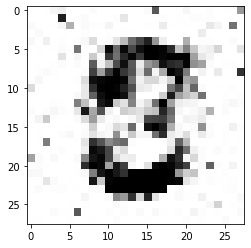

In [17]:
#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

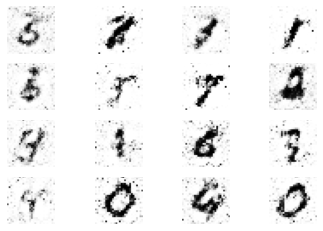

In [18]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)